# Transformator

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
f =     10**5       # Frequenz in HZ
R1 =    800.0         # Primärwiderstand in Ohm
Lp =    0.00005   # Primärinduktivität in H    
Lps =   150.0*10**-6  # Streuinduktivität in H
Lsp =   150.0*10**-6  # Streuinduktivität in H
R2 =    6.0           # Sekundärwiderstand in Ohm
Ls =    500*10**-6  # Sekundärinduktivität in H
U0 =    4.0           # Leerlaufspannung in V

print("f:", f, " R1:", R1, " Lp:", Lp, " Lps:", Lps, " Lsp:", Lsp, " R2:", R2, " Ls:", Ls, " U0:", U0)


f: 100000  R1: 800.0  Lp: 5e-05  Lps: 0.00015  Lsp: 0.00015  R2: 6.0  Ls: 0.0005  U0: 4.0


### Aufgabe 1: Differenzialgleichung für Primär und Sekundärstromkreis

### Aufgabe 2: Differenzialgleichungssystem Aufstellen

### Aufgabe 3: GLS lösen mit Eueler-vorwärts, Stabilitätsgrenze ermitteln für die Schrittweite tau.

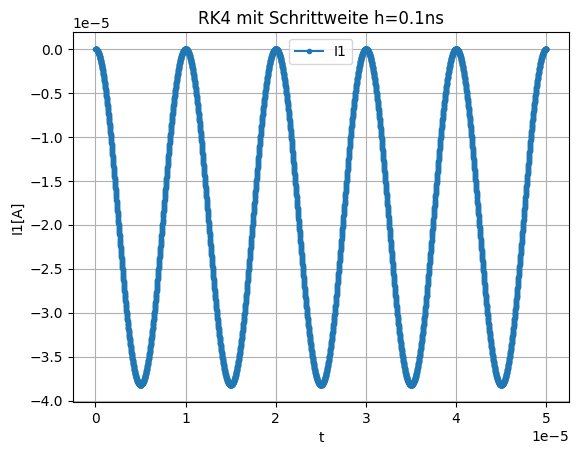

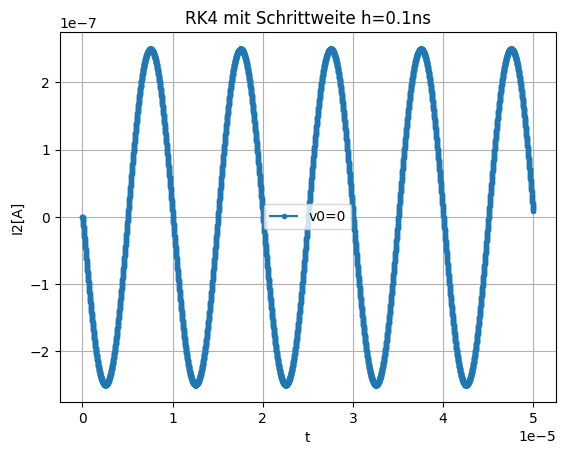

In [6]:
def eulerforward_2Systeme(t0, x0, h, tend, f):
    # t0: Anfangszeit
    # x0: Anfangswerte
    # h: Schrittweite
    # tend: Zeit bis zum Ende
    # f: Funktion mit n Gleichungen
    N = int(tend / h) +1
    

    # Vektor mit dx-daten und x-daten
    x = np.zeros((N, np.shape(x0)[0]))

    # Zeitvektor
    t = np.zeros((N))
    
    x[0][0] = x0[0]
    x[0][1] = x0[1]

    for i in range(1, N):
        t[i] = t[i-1] + h

        k1 = f(t[i], x[i-1,:])
        x[i, 0] = x[i-1, 0] + h*k1[1] #dx
        x[i, 1] = x[i-1, 1] + h*k1[0] #x

    return t, x

def model2(t, x):
    t = t
    x0 = x[0] # I1
    x1 = x[1] # I2

    U0 = 4*np.sin(2*np.pi*f*t)
    return np.array([(R2*x0*Lps*Ls - R1*x1*(1/Lp)-U0) / (1 - (Lsp*Lps*Ls)),
                      ((R1*x1)-U0)/((Lp/Lsp)-Lps)])

x0 = (0.0, 0.0)
tend = 0.00005
h =    0.00000001

t2, I_x2 = eulerforward_2Systeme(0, x0,h,tend, model2)

# =================== Plot erstellen ===================
plt.figure(1)
plt.plot(t2, I_x2[:,0],  '.-', label='I1')
plt.ylabel('I1[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)

plt.figure(2)
plt.plot(t2, I_x2[:,1],  '.-', label='v0=0')
plt.ylabel('I2[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)
plt.show()

### Aufgabe 4: GLS lösen mit Eueler-rückwärts

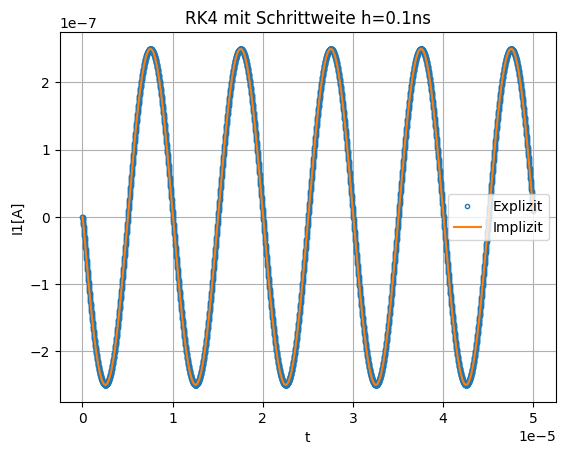

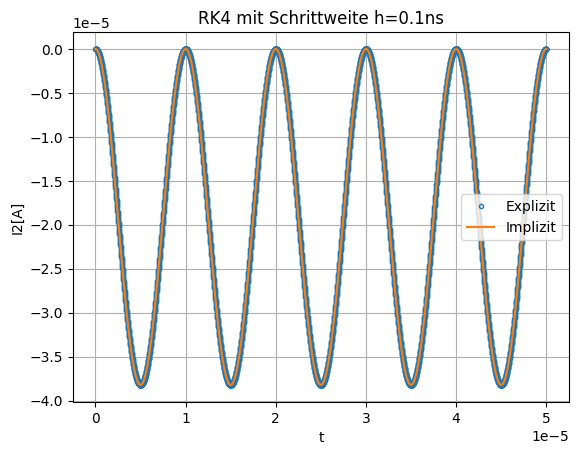

In [7]:
# C | A  =  1 | 1
#   | B  =    | 1
def runga_kutta_RK4_2Systeme_implizit(x0, h, tend, f, df, tol):
    # x0: Startpunkt
    # X: Endpunkt
    # f: Funktion
    # df: Jacobi Matrix der Funktion f
    # N: Anzahl der Schritte
    # tol: Toleranz
    max_iter=20

    N = int(tend / h)+1
    t = np.zeros(N)
    x = np.zeros((N,np.shape(x0)[0]))
   
    x[0,:] = x0
    k = f(t[0], x[0,:])

    for i in range(1,N):
        step = 0
        t[i] = t[i-1] + h

        r = k - f(t[i-1], x[i-1] + h*k)
        J = -df(t[i-1] + h, x[i-1] + h*k)
        # einheitsmatrix:
        I2 = np.eye(2)
        M = I2 - h * J

        while all(np.abs(value) > tol for value in r) and step < max_iter :
            # Solve linear system with LR
            b = -r
            ATA = np.dot(M.T, M)
            ATb = np.dot(M.T, b)
            delta_k = np.linalg.solve(ATA, ATb)
            k = k + delta_k
            r = k - f(t[i-1] + h, x[i-1] + h*k)

            step += 1

        x[i,:] = x[i-1,:] + h*k
       
    return x, t


def model1(t, x):
    t = t
    x1 = x[0] # I1
    x0 = x[1] # I2

    U0 = 4*np.sin(2*np.pi*f*t)
    return np.array([(R2*x0*Lps*Ls - R1*x1*(1/Lp)-U0) / (1 - (Lsp*Lps*Ls)),
                      ((R1*x1)-U0)/((Lp/Lsp)-Lps)])

def model1_df(x,y):
    return np.array([[-(R1*1/Lp)/(1-Lps*Lsp*1/Ls),-(R2*1/Ls*Lps)/(1-Lps*Lsp*1/Ls)],
                     [(R1/(Lp/Lsp)-Lps),0]])



# Anfangswerte, Endzeitpunkt und Schrittweite einstellen
x0 = (0.0, 0.0)
tend = 0.00005
h =    0.00000001

x_imp, t_imp = runga_kutta_RK4_2Systeme_implizit(x0, h, tend, model1, model1_df, 1e-3)

# =================== Plot erstellen ===================
plt.figure(3)
plt.plot(t_imp, x_imp[:,0],  '.', label='Explizit', markerfacecolor='none')
plt.plot(t2, I_x2[:,1],  '-', label='Implizit')
plt.ylabel('I1[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)

plt.figure(4)
plt.plot(t_imp, x_imp[:,1],  '.', label='Explizit', markerfacecolor='none')
plt.plot(t2, I_x2[:,0],  '-', label='Implizit')
plt.ylabel('I2[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)
plt.show()

### Aufgabe 5: GLS lösen mit impliziter Trapezregel und die Lösungen miteinandern vergleichen hinsichtlich der Genauigkeit, Rechenaufwand und Konvergenz.

In [8]:
 # Trapezregel implizite





def implizitEuler_DIRK(x0, X, f, df, N, A, B, C, tol):
    # x0: Startpunkt
    # X: Endpunkt
    # f: Funktion
    # df: Jacobi Matrix der Funktion f
    # N: Anzahl der Schritte
    # tol: Toleranz
    max_iter=20

    h = (X-x0[0])/(N-1)
    print( "IMP: Schrittweite: ", h)
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = x0[0]
    y[0] = x0[1]
    s = 0

    for i in range(1,N):
      
        step = 0
        
        x[i] = x[i-1] + h
        k_1 = f(x[i-1], y[i-1])
        k_2 = k_1
        r = k_2 - f(x[i-1]+h, y[i-1] + h*(k_1*A[s][0] + k_2*A[s][1]))
        
        while np.abs(r) > tol and step < max_iter:
            j = -df(x[i-1] + h*C[1], y[i-1] + h*(k_1*A[s][0] + k_2*A[s][1]))
            delta_k = -r / (1-h*j)
            k_2 += delta_k
            r = k_2 - f(x[i-1] + h*C[1], y[i-1] + h*(k_1*A[s][0] + k_2*A[s][1]))
            step += 1
        
        #print("k's: ", kl[0], kl[1])
        y[i] = y[i-1] + h*(k_1*B[0] + k_2*B[1])
    return x, y




x0 = [0.0,0.0]

# c | a
#   | b
c1 = 0.0
c2 = 1.0
a1 = [0.0, 0.0]
a2 = [0.5, 0.5]
b1 = 0.5
b2 = 0.5
A = [a1, a2]
B = [b1, b2]
C = [c1, c2]
tend = 50*10**-6
x_imp_dirk2, y_imp_dirk2 = implizitEuler_DIRK(x0, tend, model1, model1_df, 100, A, B, C ,1e-3)


x_an = np.linspace(0,1,100)
plt.figure(2)
plt.plot(x_imp_dirk2, y_imp_dirk2, 'o-', label='Diagonales Implizites Trapez (Model2)')
plt.legend()


IMP: Schrittweite:  5.05050505050505e-07


IndexError: invalid index to scalar variable.